# 🔍 Identifying missing cell types

This tutorial demonstrates how to identify **missing or unseen cell types** in new datasets using the `PANGEApy` framework.  
It showcases two representative cases:

1. **Dataset with missing cell types** – pancreatic islet dataset (contains endocrine cells *not* present in the atlas).  
2. **Dataset fully represented by the atlas** – peripheral blood dataset (all common immune cell types are covered).  

Through these examples, we will see how PANGEApy’s **uncertainty estimation** helps detect potential out-of-distribution or novel cell populations.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sc.settings.verbosity = 0
sc.settings.set_figure_params(facecolor='white', frameon=False)
sns.set_style("white")

In [2]:
from pangeapy.cell import CellAnnotator
from pangeapy.meta import MetaAnnotator

cell_anno = CellAnnotator()
meta_anno = MetaAnnotator()

/home/smcheong/.local/lib/python3.11/site-packages/celltypist/classifier.py:11: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  from scanpy import __version__ as scv


Checking-up download status of anno_models
Checking-up download status of meta_models


## Example 1 - Dataset with Missing Cell Types

In this example, we analyze the **pancreatic islet** dataset from *Craig-Schapiro et al., 2025, Nature Communications*. (https://www.nature.com/articles/s41467-024-55415-3)

This dataset includes **endocrine cells**, which are **not represented** in the PANGEA reference atlas.  
Thus, this case demonstrates how the model behaves when it encounters **previously unseen cell types**.

We expect that the **uncertainty scores** for these missing cell types will be **high**, indicating potential out-of-distribution detection.

In [3]:
adata = sc.read("/nfs/SCMGL/smc00_ref/pangeapy_docs/adata_postprocessing_islet_bbknn.h5ad")

In [4]:
adata

AnnData object with n_obs × n_vars = 33077 × 36601
    obs: 'Sample', 'predicted_labels', 'majority_voting', 'conf_score', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'GSM', 'key', 'leiden', 'label', 'over_clustering'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'label_colors', 'leiden', 'leiden_colors', 'log1p', 'majority_voting_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

The figure below shows the original labels provided by the authors.  
Since endocrine cells are **not part of the PANGEA model training**, they serve as a “missing” cell type for our model.

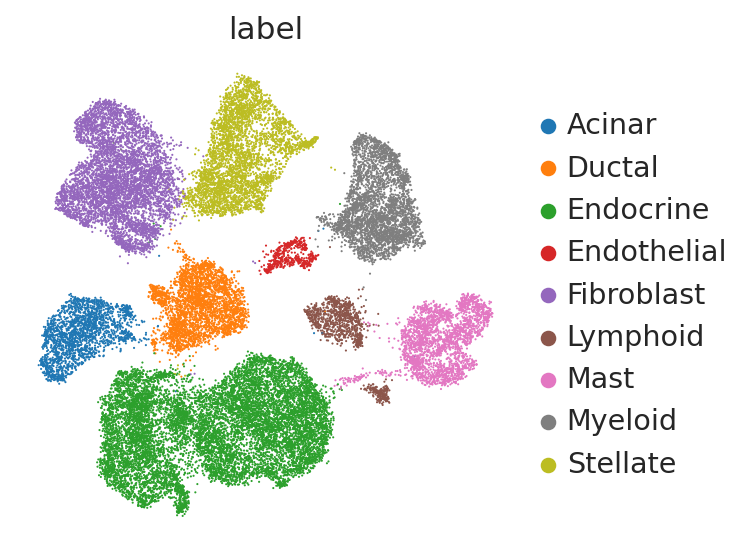

In [5]:
# Visualize the original annotations.
sc.pl.umap(adata, color='label')

### Run cell type prediction with uncertainty estimation

We use the `compute_uncertainty=True` option to calculate per-cell uncertainty scores, which allow us to flag cells that the model is less confident about - typically those not well represented in the reference atlas.

In [6]:
pred = cell_anno.annotate(adata, compute_uncertainty=True)

conducting Level1 annotation...
conducting Level2 annotation...
computing uncertainty scores...


In [7]:
# Merge prediction results with AnnData.obs

pred = pred.drop('Sample', axis = 1)
adata.obs = adata.obs.join(pred)

### Visualize predicted annotations and uncertainty

The UMAP plots below show both the **predicted major cell types (Level 1)** and the **uncertainty flags**.

... storing 'Level2|predicted_labels' as categorical
... storing 'Level2|over_clustering' as categorical
... storing 'Level2|majority_voting' as categorical
... storing 'PG_annotations' as categorical


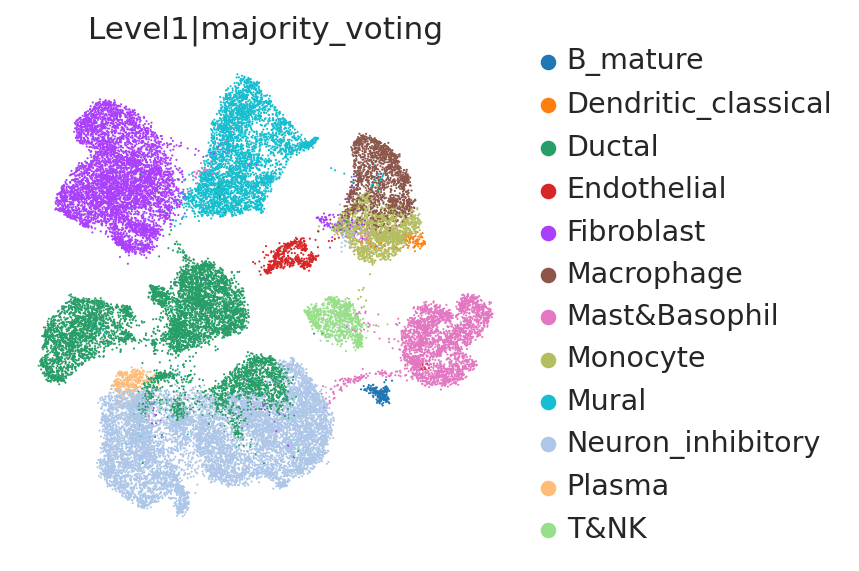

In [8]:
sc.pl.umap(adata, color='Level1|majority_voting')

Cells marked with `pred_uncert = True` correspond to regions where the model is uncertain - often representing missing or novel cell types.  
You will notice that endocrine cells are incorrectly predicted as *Neuron_inhibitory* or *Endothelial* cells, and they are also flagged as **uncertain**.

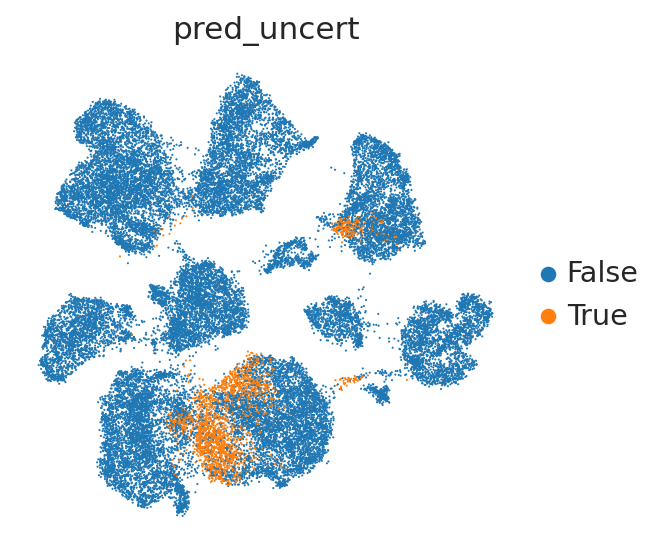

In [9]:
sc.pl.umap(adata, color = 'pred_uncert')

We can also examine how uncertainty varies across the original cell labels.  
High mean `score_uncert` values indicate that the corresponding cell type was not present in the reference atlas.

Text(0.5, 1.0, 'Average uncertainty score by original label')

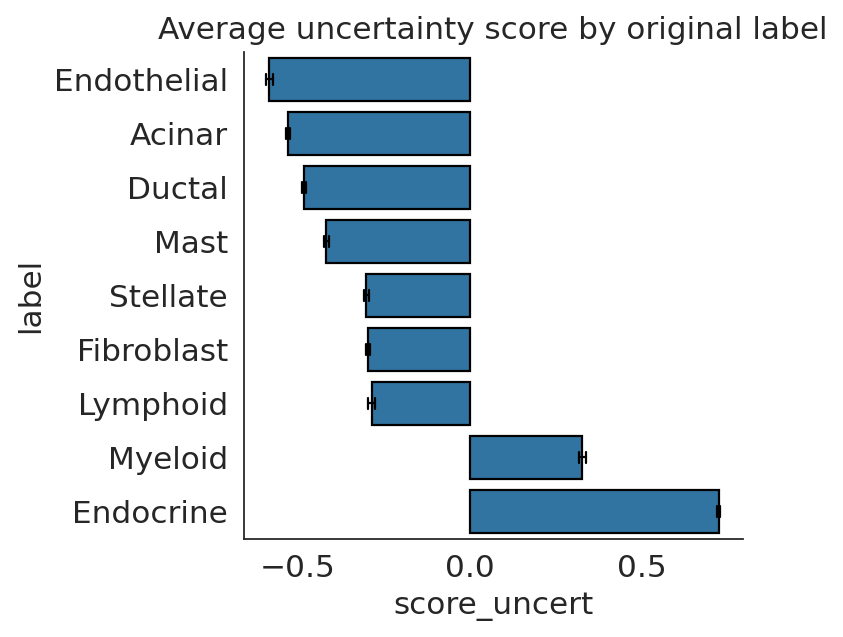

In [10]:
order = adata.obs.groupby("label")['score_uncert'].mean().sort_values().index

sns.barplot(
    data=adata.obs, 
    y='label', x='score_uncert', 
    order=order,
    errorbar='se',
    capsize=.2,
    errwidth=1, 
    errcolor='black',
    linewidth=1,
    edgecolor='black'
)
sns.despine()
plt.title("Average uncertainty score by original label")

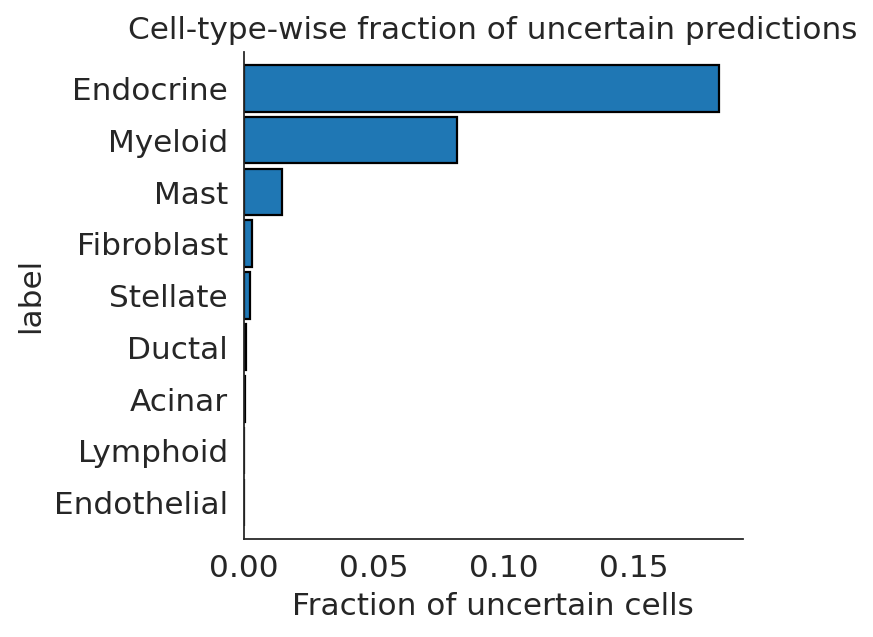

In [11]:
# Show fraction of uncertain cells per label
conf_mtx = pd.crosstab(adata.obs['label'], adata.obs['pred_uncert'], normalize=0)
conf_mtx[True].sort_values().plot.barh(width=0.9, linewidth=1, edgecolor='black')
plt.xlabel('Fraction of uncertain cells')
plt.title('Cell-type-wise fraction of uncertain predictions')
sns.despine()

Again, endocrine cells show the highest uncertainty rates, reflecting that they are missing from the atlas.

## Example 2 - Dataset Fully Represented by the Atlas

In contrast, this example uses a dataset that **contains only common immune cell types**, all of which are well represented in the PANGEA reference.

We use the **peripheral blood mononuclear cell (PBMC)** dataset from *Zu et al., 2020, Immunity*.  
(https://www.sciencedirect.com/science/article/pii/S1074761320303162?via%3Dihub)

This serves as a **control example**: since all cell types are known, the model should show **low and consistent uncertainty scores** across the dataset.

In [12]:
adata = sc.read("/nfs/SCMGL/smc00_ref/pangeapy_docs/Final_nCov.h5ad")

In [13]:
adata

AnnData object with n_obs × n_vars = 46022 × 18824
    obs: 'nCount_RNA', 'nFeature_RNA', 'batch', 'percent.mt', 'seurat_clusters', 'cell_type', 'integrated_snn_res.0.8', 'Stage'
    var: 'name'
    uns: 'pca'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

### Original annotations

All cell types in this dataset (e.g., T cells, B cells, monocytes, NK cells) are part of the PANGEA reference atlas.

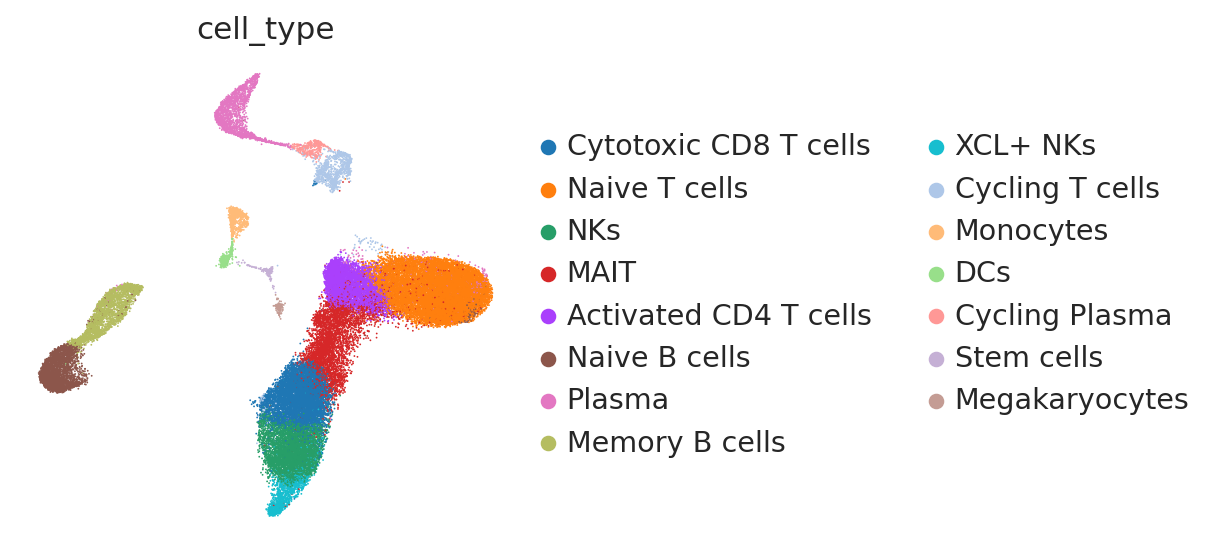

In [14]:
sc.pl.umap(adata, color='cell_type')

### Run PANGEA-py annotation

Since this dataset is fully represented in the atlas, we expect the model to predict the correct cell types with **high confidence** and **low uncertainty**.

In [15]:
pred = cell_anno.annotate(adata, compute_uncertainty=True)

conducting Level1 annotation...


/home/smcheong/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


conducting Level2 annotation...
computing uncertainty scores...
⚠️ Graph 'distances' not found; computing neighbors...


In [16]:
# Merge prediction results with AnnData.obs
adata.obs = adata.obs.join(pred)

### Visualize predictions and uncertainty

The UMAP plots show strong correspondence between the predicted and original labels.  

... storing 'Level2|predicted_labels' as categorical
... storing 'Level2|over_clustering' as categorical
... storing 'Level2|majority_voting' as categorical
... storing 'PG_annotations' as categorical
... storing 'Sample' as categorical


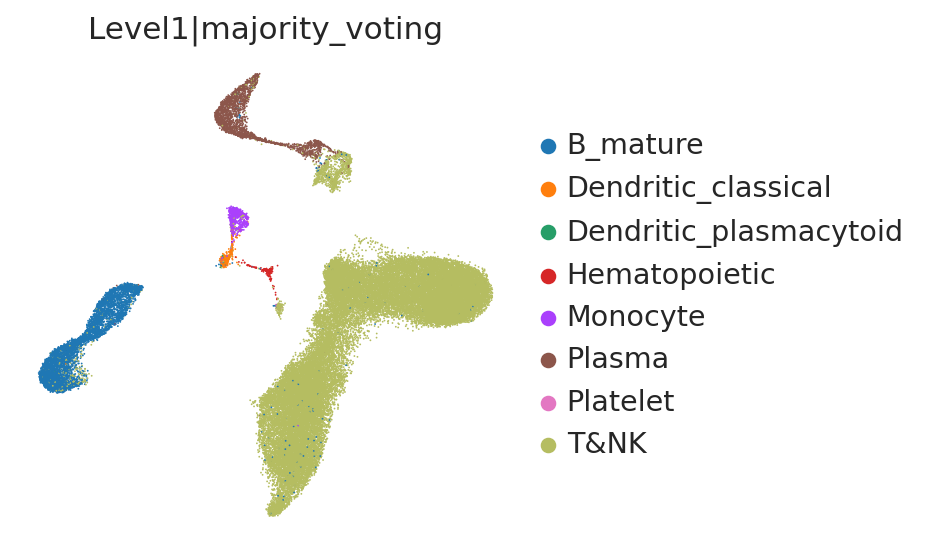

In [17]:
sc.pl.umap(adata, color='Level1|majority_voting')

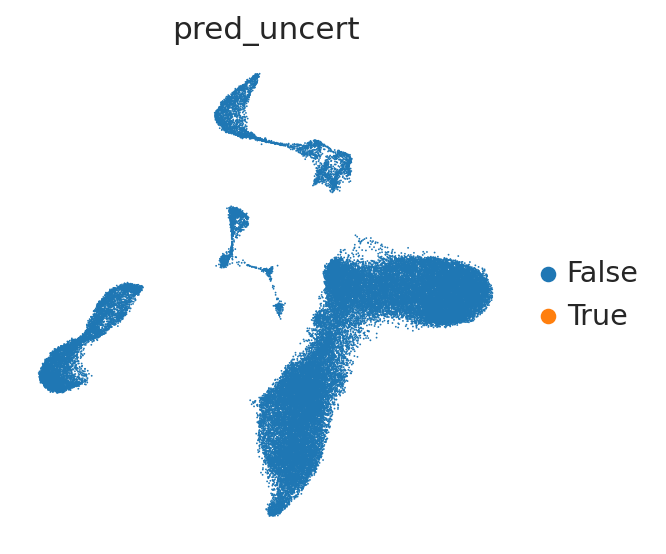

In [18]:
sc.pl.umap(adata, color='pred_uncert')

In [19]:
adata.obs.value_counts('pred_uncert')

pred_uncert
False    46022
True         0
Name: count, dtype: int64

All cells have **low uncertainty**, confirming that PANGEApy recognizes all major immune cell types in this dataset.

## Summary

This tutorial demonstrated how **PANGEApy** can identify unseen or missing cell types by leveraging **uncertainty estimation**.

- When a dataset includes **cell types not present** in the reference atlas (e.g., endocrine cells in the islet dataset), the model produces **high uncertainty scores** and misclassifies those cells as the most similar known types.  
- When a dataset is **fully covered** by the reference (e.g., PBMCs), uncertainty scores remain **low**, indicating confident predictions.

## Package versions

In [20]:
sc.logging.print_header()

Package,Version
pandas,2.3.3
anndata,0.12.6
matplotlib,3.10.7
scanpy,1.11.5
numpy,2.3.4
seaborn,0.13.2
pangeapy,0.0
Component,Info
Python,"3.11.13 (main, Jun 5 2025, 13:12:00) [GCC 11.2.0]"
OS,Linux-5.4.0-150-generic-x86_64-with-glibc2.27
